# AlexNet

## Import the required libraries and dependencies.

In [1]:
import numpy as np
import cv2
from os import listdir
import tensorflow as tf
import pickle
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers.core import Activation, Flatten, Dropout, Dense, Reshape
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import img_to_array
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras import regularizers
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Initialize hyperparameters.
EPOCHS = 15
INIT_LR = 1e-4
DECAY = 1e-6
BS = 32
default_image_size = tuple((256, 256))
resized_image_size = tuple((224,224))
image_size = 0
directory_root = 'plantdisease'

## Load the dataset for use.

In [3]:
# Function to convert image to array.
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, resized_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
# Reading the images from the dataset folder.
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed!")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing PlantVillage ...
[INFO] Image loading completed!


In [5]:
image_size = len(image_list)

In [6]:
# Assign the classes to images.
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

In [7]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [8]:
# Convert the array to a NumPy list and normalise it.
np_image_list = np.array(image_list, dtype = np.float16) / 223.0

## Split the NumPy list into test and train set.

In [9]:
print("[INFO] Spliting data into train set and test set ...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size = 0.2, random_state = 42) 
print("[INFO] Spliting complete!")

[INFO] Spliting data into train set and test set ...
[INFO] Spliting complete!


## Initialize a Image Data Generator object.

In [10]:
aug = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2, 
    zoom_range = 0.2,
    horizontal_flip = True, 
    fill_mode = "nearest")

## Build an AlexNet.

In [11]:
# Initialize the model.
model = Sequential()
          
# 1st Convolutional Layer
model.add(Conv2D(filters = 96, input_shape = (224,224,3), kernel_size = (11,11), strides = (4,4), padding = 'valid'))
model.add(Activation('relu'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())
# Pooling Layer
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters = 256, kernel_size = (5,5), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Pooling Layer
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Dropout
model.add(Dropout(0.5))

# 4th Convolutional Layer
model.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Dropout
model.add(Dropout(0.5))

# 5th Convolutional Layer
model.add(Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Pooling Layer
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid'))
# Dropout
model.add(Dropout(0.5))

# Passing it to a dense layer
model.add(Flatten())

# 1st Dense Layer
model.add(Dense(4096, input_shape = (224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.25))
# Batch Normalisation
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.5))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.5))
# Batch Normalisation
model.add(BatchNormalization())

# Output Layer
model.add(Dense(n_classes))
model.add(Activation('softmax'))

# Get the model summary.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 54, 54, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 256)       1

## Compile the model.

In [12]:
# Compile 
opt = tf.keras.optimizers.Adam(lr = INIT_LR, decay = DECAY)
model.compile(loss="binary_crossentropy", optimizer = opt,metrics = ["accuracy"])
print("[INFO] Training network...")

# Train
checkpoint = ModelCheckpoint("AlexNet.h5", monitor = 'accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto', period = 1)

history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size = BS, shuffle = False),
    validation_data = (x_test, y_test),
    steps_per_epoch = len(x_train) // BS,
    callbacks = [checkpoint],
    epochs = EPOCHS,
    verbose=1 )

[INFO] Training network...
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 73 steps, validate on 591 samples
Epoch 1/15
72/73 [============================>.] - ETA: 0s - loss: 0.2917 - accuracy: 0.9247
Epoch 00001: accuracy improved from -inf to 0.92471, saving model to AlexNet.h5
73/73 [==============================] - 72s 993ms/step - loss: 0.2916 - accuracy: 0.9247 - val_loss: 0.3336 - val_accuracy: 0.9333
Epoch 2/15
72/73 [============================>.] - ETA: 0s - loss: 0.2689 - accuracy: 0.9234
Epoch 00002: accuracy did not improve from 0.92471
73/73 [==============================] - 73s 1s/step - loss: 0.2688 - accuracy: 0.9234 - val_loss: 0.4554 - val_accuracy: 0.8746
Epoch 3/15
72/73 [============================>.] - ETA: 0s - loss: 0.2535 - accuracy: 0.9247
Epoch 00003: accuracy did not improve from 0.92471
73/73 [==============================] - 69s 946ms/step - loss: 0.2537 - accuracy: 0.9247 - val_loss: 0

## Plot the accuracy and loss curves.
This is done to identify if the model is performing well or is overfitting/underfitting the dataset.

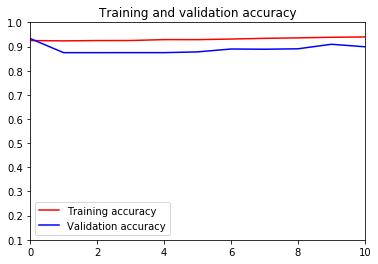

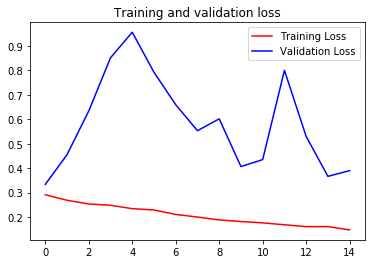

In [13]:
import matplotlib.pyplot as plt
xmin = 0
xmax = 15
ymin = 0.0
ymax = 1.0
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])

plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Calculate model accuracy.

In [14]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
591/591 [==============================] - 3s 5ms/sample - loss: 0.3900 - accuracy: 0.9093
Test Accuracy: 90.9306287765503


## Save the model to disk.

In [15]:
print("[INFO] Saving model...")
model.save("Model_AlexNet.h5")
print("[INFO] Saved model to disk!")

[INFO] Saving model...
[INFO] Saved model to disk!
